# Assignment 2 — Starter Notebook

Fill in the TODO sections.


In [2]:
# Imports
import os
from pathlib import Path
import random
import time

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as T

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

def set_seed(seed: int = 0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

#set_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda:0


In [3]:
def show_grid(imgs, nrow=8, title="", cmap=None, resize_to=None):
    import math
    import torchvision
    import torch.nn.functional as F
    import matplotlib.pyplot as plt

    if len(imgs) == 0:
        return

    proc = []
    shapes = []
    for x in imgs:
        x = x.detach().cpu()
        if x.ndim == 2:
            x = x.unsqueeze(0)
        proc.append(x)
        shapes.append((int(x.shape[1]), int(x.shape[2])))

    if resize_to is None and len(set(shapes)) > 1:
        resize_to = (min(h for h, w in shapes), min(w for h, w in shapes))

    if resize_to is not None:
        th, tw = int(resize_to[0]), int(resize_to[1])
        resized = []
        for x in proc:
            if int(x.shape[1]) == th and int(x.shape[2]) == tw:
                resized.append(x)
                continue
            xb = x.unsqueeze(0)
            mode = "nearest" if x.shape[0] == 1 else "bilinear"
            xb = F.interpolate(xb, size=(th, tw), mode=mode, align_corners=False if mode == "bilinear" else None)
            resized.append(xb.squeeze(0))
        proc = resized

    grid = torchvision.utils.make_grid(proc, nrow=nrow, padding=2)
    grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(nrow * 1.2, max(1, math.ceil(len(imgs) / nrow)) * 1.2))
    if grid.shape[2] == 1:
        plt.imshow(grid[:, :, 0], cmap=cmap)
    else:
        plt.imshow(grid)
    plt.title(title)
    plt.axis("off")
    plt.show()


## Textures (provided)

Download the provided `textures.zip` from **Canvas → Files**, then upload it to Colab (Files panel).
Keep the filename as **`textures.zip`**. The next cell will extract images into `/content/textures/`.

Alternatively, you may upload individual texture images directly into `/content/textures/`.


In [4]:
from pathlib import Path
import zipfile

def list_texture_files(texture_dir: Path):
    exts = (".png", ".jpg", ".jpeg", ".bmp")
    return [p for p in sorted(texture_dir.iterdir()) if p.is_file() and p.suffix.lower() in exts]

In [5]:
TEXTURE_DIR = Path("content/textures")
TEXTURE_DIR.mkdir(parents=True, exist_ok=True)



texture_files = list_texture_files(TEXTURE_DIR)

# If the folder is empty, extract from /content/textures.zip.
if len(texture_files) == 0:
    ZIP_PATH = Path("content/textures.zip")
    if not ZIP_PATH.exists():
        raise FileNotFoundError(
            "No texture images found in /content/textures.\n"
            "Upload the provided texture archive and name it 'textures.zip', then re-run this cell."
        )

    exts = {".png", ".jpg", ".jpeg", ".bmp"}
    counts = {}
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        for info in z.infolist():
            if info.is_dir():
                continue
            name = info.filename
            if "__MACOSX" in name:
                continue
            suf = Path(name).suffix.lower()
            if suf not in exts:
                continue
            base = Path(name).name  # flatten
            counts.setdefault(base, 0)
            out = TEXTURE_DIR / base
            if counts[base] > 0:
                out = TEXTURE_DIR / f"{Path(base).stem}_{counts[base]}{suf}"
            counts[base] += 1
            with z.open(info) as src, open(out, "wb") as dst:
                dst.write(src.read())

    texture_files = list_texture_files(TEXTURE_DIR)

print("Found texture images:", len(texture_files))
for p in texture_files[:20]:
    print(" -", p.name)

if len(texture_files) == 0:
    raise RuntimeError("textures.zip extracted no images; check the archive contents.")

Found texture images: 12
 - 1.png
 - 10.png
 - 11.png
 - 12.png
 - 2.png
 - 3.png
 - 4.png
 - 5.png
 - 6.png
 - 7.png
 - 8.png
 - 9.png


In [6]:
def load_texture_as_tensor(path: Path, resize: int | None = None):
    """Return (C,H,W) float tensor in [0,1]."""
    img = Image.open(path).convert("RGB")
    if resize is not None:
        img = img.resize((resize, resize), Image.BILINEAR)
    x = torch.from_numpy(np.array(img)).float() / 255.0
    x = x.permute(2, 0, 1).contiguous()
    return x

def extract_patches_from_image(img: torch.Tensor, window: int, max_patches: int | None = None, device: torch.device = device):
    """img: (C,H,W) -> patches: (N,C,window,window)."""
    assert img.ndim == 3
    C, H, W = img.shape
    assert window <= H and window <= W
    unfold = torch.nn.Unfold(kernel_size=window, padding=0, stride=1)
    patches = unfold(img.unsqueeze(0))
    patches = patches.transpose(1, 2).reshape(-1, C, window, window)
    if max_patches is not None and patches.shape[0] > max_patches:
        idx = torch.randperm(patches.shape[0])[:max_patches]
        patches = patches[idx]
    return patches.to(device)


In [7]:
def compute_frontier(known: torch.Tensor, valid: torch.Tensor, neighborhood: int = 8) -> torch.Tensor:
    """
    known, valid: (H,W) bool
    frontier: unknown & valid & adjacent-to-known
    neighborhood: 4 or 8

    Implementation hint:
      - Use a 3x3 convolution over the known-mask to count known neighbors.
      - For 8-neighborhood: use a 3x3 all-ones kernel with center = 0.
      - For 4-neighborhood: use a cross-shaped kernel.

    Return:
      frontier: (H,W) bool
    """
    assert known.shape == valid.shape
    H, W = known.shape
    known_f = known.float().view(1, 1, H, W)
    if neighborhood == 8:
        # 3x3 all-ones kernel with center = 0, on the same device as `known`
        k = torch.ones((3,3), device=known.device, dtype=torch.float32)
        k[1,1] = 0
        k = k.view(1,1,3,3)
    elif neighborhood == 4:
        # 3x3 cross-shaped kernel, on the same device as `known`
        k = torch.tensor(
            [[0, 1, 0],
            [1, 1, 1],
            [0, 1, 0]], device=known.device, dtype=torch.float32).view(1,1,3,3)
    else:
        raise ValueError("neighborhood must be 4 or 8")

    # Count known neighbors at each pixel
    nb = F.conv2d(known_f, k, padding=1).view(H, W)
    # Frontier = unknown pixels that are valid and have at least one known neighbor
    frontier = (~known) & valid & (nb > 0)
    return frontier


In [8]:
def choose_seed_patch_index(patches: torch.Tensor, seed_fg_min: int = 0) -> int:
    """
    Choose an index into the patch pool for the initial seed.

    If seed_fg_min > 0, prefer patches whose total foreground mass (sum over all elements)
    is at least seed_fg_min. If no patch satisfies the constraint, fall back to uniform random.

    TODO:
      - Implement the logic described above.
      - Return a Python int index.
    """
    assert seed_fg_min >= 0
    if seed_fg_min == 0:
        return torch.randint(0,patches.shape[0],(1,)).item()
    else:
        sums = patches.reshape(patches.shape[0], -1).sum(dim=1)  # (N,)
        mask = sums > seed_fg_min
        valid_indices = mask.nonzero(as_tuple=True)[0]
        
        # If no patch satisfies constraint, fall back to uniform random
        if valid_indices.shape[0] == 0:
            return torch.randint(0, patches.shape[0], (1,)).item()
        
        # Sample uniformly from valid indices
        choice = torch.randint(0, valid_indices.shape[0], (1,)).item()
        return valid_indices[choice].item()


def choose_frontier_pixel(
    frontier: torch.Tensor,   # (H,W) bool
    known: torch.Tensor,      # (H,W) bool
    ones_w: torch.Tensor,     # (1,1,w,w) float
    pad: int,
) -> tuple[int, int]:
    """
    Pick a pixel (y,x) from the frontier with the *maximum* number of known pixels
    in its w×w neighborhood window. Break ties uniformly at random.

      - Use a conv2d with kernel ones_w to compute known_count map.
      - Restrict to pixels where frontier==True.
      - Return (y,x) as Python ints.
    """
    H, W = known.shape
    known_f = known.float().view(1, 1, H, W)
    known_nb = F.conv2d(known_f, ones_w, padding='same').view(H,W)

    valid_pixels = (known_nb > 0) & frontier
    valid_pixel_nb = valid_pixels*known_nb
    
    max_val = torch.max(valid_pixel_nb)
    max_mask = (valid_pixel_nb == max_val)
    indices_of_max = max_mask.nonzero()
    choice = torch.randint(0,indices_of_max.shape[0], (1,)).item()
    return indices_of_max[choice]


def masked_ssd(
    tgt_patch: torch.Tensor,     # (C,w,w)
    patches_flat: torch.Tensor,  # (N,C,w*w)
    mask: torch.Tensor,          # (w*w) bool
) -> torch.Tensor:
    """
    Compute masked SSD distance between a target patch and each candidate patch.

      - Flatten tgt_patch to (C,w*w) and keep only masked entries -> (C,K)
      - Select the same masked entries from patches_flat -> (N,C,K)
      - Return dist: (N,) where dist[n] = sum_{c,k} (cand - tgt)^2
    """
    
    tgt_flat = tgt_patch.reshape(tgt_patch.shape[0], -1)
    masked_patches = patches_flat*mask

    return torch.linalg.vector_norm((masked_patches - tgt_flat), ord=2, dim=2).sum(dim=1)


def candidate_set(dist: torch.Tensor, eps: float) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Candidate set rule from Efros & Leung:
      { i | dist[i] <= (1+eps) * dmin }, where dmin = min(dist)

      - Compute dmin (a scalar tensor)
      - Return (cand_idx, dmin), where cand_idx is 1D LongTensor of indices
      - Handle any edge cases (e.g., empty candidate set)
    """
    dmin = dist.min()
    candidate_mask = (dist <= (1+eps) * dmin)
    candidate_indices = candidate_mask.nonzero()
    return (candidate_indices, dmin)


def sample_from_candidates(
    cand_idx: torch.Tensor,   # (M,)
    dist: torch.Tensor,       # (N,)
    dmin: torch.Tensor,       # scalar
    weighted: bool = True,
    h_mult: float = 0.3,
) -> int:
    """
    Sample one candidate index from cand_idx.

    If weighted=True, sample with probability proportional to
        exp( - (dist[i] - dist_min_over_cands) / (h_mult*dmin + 1e-6) ).

    Otherwise, sample uniformly from cand_idx.
      - Implement both sampling modes.
      - Return the *chosen* index as a Python int.
    """
    if weighted:
        candidates = dist[cand_idx]
        dist_min_over_cands = torch.min(candidates)
        weights = torch.exp(-(candidates - dist_min_over_cands) / (h_mult * dmin + 1e-6))
        # Normalize weights to sum to 1
        weights = weights / weights.sum()
        # Sample from the candidates using multinomial
        sampled_idx = torch.multinomial(weights.view(-1), 1)
        return cand_idx[sampled_idx].item()
    else:
        # sample uniformly
        return cand_idx[torch.randint(0, cand_idx.shape[0], (1,)).item()].item()

In [9]:
def efros_leung_synthesize_from_patch_pool(
    patches: torch.Tensor,  # (N,C,w,w)
    out_h: int,
    out_w: int,
    eps: float = 0.05,
    neighborhood: int = 8,
    seed_fg_min: int = 0,
    border: int = 0,
    weighted: bool = True,
    h_mult: float = 0.3,
    verbose: bool = False,
    return_stats: bool = False,
    max_steps: int | None = None,
):
    """
    Efros–Leung synthesis using a pre-built patch pool.

    Core algorithmic requirements (you must implement):
      - Initialize output with a random seed patch.
      - Maintain a frontier set (unknown pixels adjacent to known).
      - Pick a frontier pixel with the most known neighbors in its w×w window.
      - Compute masked SSD between the target neighborhood and each candidate patch.
      - Candidate set: d <= (1+eps)*dmin. Sample one candidate (uniform or weighted).
      - Copy the *center pixel only* from the sampled candidate patch.

    Args:
      patches: (N,C,w,w) float in [0,1]
      return_stats: if True, return (out, stats) where stats includes a match-error score

    Return:
      out: (C,out_h,out_w) on CPU if return_stats=False
      (out, stats) if return_stats=True
    """
    assert patches.ndim == 4
    N, C, w, _ = patches.shape
    assert w % 2 == 1, "window size must be odd"
    pad = w // 2

    # Precompute flattened patches and their center pixels
    patches_flat = patches.reshape(N, C, -1)  # (N,C,w*w)
    center = w // 2
    center_pixels = patches[:, :, center, center]  # (N,C)

    # pick the seed patch index
    seed_idx = choose_seed_patch_index(patches, seed_fg_min)

    # Allocate padded output and masks
    H, W = int(out_h), int(out_w)
    out = torch.zeros((C, H + 2 * pad, W + 2 * pad), device=patches.device, dtype=torch.float32)
    known = torch.zeros((H + 2 * pad, W + 2 * pad), device=patches.device, dtype=torch.bool)
    valid = torch.zeros_like(known)
    valid[pad : pad + H, pad : pad + W] = True

    # initialize with the seed patch at the center of the valid region
    left_side = -w//2
    right_side = w//2
    cntr_pix = (pad+H//2, pad+W//2)
    out[:,cntr_pix[0] + left_side:cntr_pix[0] + right_side, 
        cntr_pix[1] + left_side:cntr_pix[1] + right_side] = patches[seed_idx]
    known[cntr_pix[0] + left_side:cntr_pix[0] + right_side,
          cntr_pix[1] + left_side:cntr_pix[1] + right_side] = 1
    #TODO remove plotting sanity check code 
    #plt.imshow(out.permute(1, 2, 0).numpy())
    #plt.show()

    # Optional known border (often useful on MNIST to avoid wandering)
    if border > 0:
        top, bottom = pad, pad + H
        left, right = pad, pad + W
        out[:, top : top + border, left:right] = 0.0
        out[:, bottom - border : bottom, left:right] = 0.0
        out[:, top:bottom, left : left + border] = 0.0
        out[:, top:bottom, right - border : right] = 0.0

        known[top : top + border, left:right] = True
        known[bottom - border : bottom, left:right] = True
        known[top:bottom, left : left + border] = True
        known[top:bottom, right - border : right] = True

    total_to_fill = int(valid.sum().item())
    pbar = tqdm(total=total_to_fill, disable=not verbose)
    pbar.update(int((known & valid).sum().item()))

    ones_w = torch.ones((1, 1, w, w), device=patches.device, dtype=torch.float32)

    dmin_hist = []

    with torch.no_grad():
        steps = 0
        while int((known & valid).sum().item()) < total_to_fill:
            if max_steps is not None and steps >= int(max_steps):
                break

            frontier = compute_frontier(known, valid, neighborhood=neighborhood)

            #if steps%100 == 0:
                #plt.imshow(out.permute(1, 2, 0).numpy())
                #plt.show()
            if frontier.sum().item() == 0:
                break

            # select the next pixel to fill from the frontier
            y, x = choose_frontier_pixel(frontier, known, ones_w, pad)

            tgt_patch = out[:, y - pad : y + pad + 1, x - pad : x + pad + 1]
            tgt_known = known[y - pad : y + pad + 1, x - pad : x + pad + 1].reshape(-1)
            mask = tgt_known.bool()

            if mask.sum().item() == 0:
                # No known neighbors yet: fall back to a random center pixel
                ridx = torch.randint(0, N, (1,), device=patches.device).item()
                out[:, y, x] = center_pixels[ridx]
                known[y, x] = True
                pbar.update(1)
                steps += 1
                continue

            # compute dist over all candidate patches using masked SSD
            dist = masked_ssd(tgt_patch, patches_flat, mask)

            # candidate-set selection
            cand_idx, dmin = candidate_set(dist, eps)

            # sample a candidate index from the candidate set
            chosen = sample_from_candidates(cand_idx, dist, dmin, weighted, h_mult)

            out[:, y, x] = center_pixels[chosen]
            known[y, x] = True
            pbar.update(1)

            dmin_hist.append(float(dmin.item()))
            steps += 1

    pbar.close()
    out = out[:, pad : pad + H, pad : pad + W].detach().cpu()

    if not return_stats:
        return out

    stats = {
        "steps": steps,
        "filled": int((known & valid).sum().item()),
        "avg_dmin": float(np.mean(dmin_hist)) if len(dmin_hist) > 0 else float("nan"),
        "dmin_hist": dmin_hist,
    }
    return out, stats


  0%|          | 0/4096 [00:00<?, ?it/s]

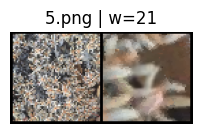

In [9]:
# ---- Part 1 demo (will run after you implement the TODOs) ----
OUT_H, OUT_W = 64, 64
WINDOWS = [21]          # TODO (tuning): try e.g. [5, 11]
EPS = 0.04            # TODO (tuning): try e.g. 0.02, 0.05, 0.1
MAX_PATCHES = 100000     # e.g., 50000 to cap candidates for speed/memory
RESIZE_SRC = None       # resize textures for consistent runtime
NEIGHBORHOOD = 8      # 4 or 8
VERBOSE = True

for path in texture_files[7:8]:
    src = load_texture_as_tensor(path, resize=RESIZE_SRC).to(device)
    for w in WINDOWS:
        patches = extract_patches_from_image(src, window=w, max_patches=MAX_PATCHES, device=device)
        out, stats = efros_leung_synthesize_from_patch_pool(
            patches=patches,
            out_h=OUT_H, out_w=OUT_W,
            eps=EPS,
            neighborhood=NEIGHBORHOOD,
            seed_fg_min=0,
            border=0,
            weighted=False,
            h_mult=0.3,
            verbose=VERBOSE,
            return_stats=True,
        )
        show_grid([src.cpu(), out], nrow=2, resize_to=(OUT_H, OUT_W), title=f"{path.name} | w={w}")
    break


## (Required) Tuning / Ablations

This assignment is *not* meant to be one-run-and-done. You should **tune** the key hyperparameters and report what changes.

Minimum tuning expectations (include in the report):

- **Part 1 (textures):** tune `window` size and `eps` (candidate-set threshold).
- **Part 2 (MNIST):** tune `window` size and `eps` (and optionally `seed_fg_min`, `border`, `weighted`).
- **Part 3 (PixelRNN):** tune at least one of: `hidden_dim`, `num_layers`, `dropout`, `lr`, `temperature`.

Below is an optional helper scaffold to run small sweeps. Fill in the TODOs if you want
a clean tuning workflow (recommended).


In [10]:
from itertools import product

def tune_efros_grid(
    texture: torch.Tensor,
    patch_pool_builder,
    window_list,
    eps_list,
    out_h: int,
    out_w: int,
    trials: int = 1,
    synth_kwargs: dict | None = None,
    max_steps: int | None = None,
    texture_name: str = "",
):
    """
    Grid-search over (window, eps) for Efros–Leung.

    Args:
      patch_pool_builder: function(window:int) -> patches (N,C,window,window) on `device`
      window_list: list of odd window sizes to try, e.g. [5, 11]
      eps_list: list of eps to try, e.g. [0.02, 0.05, 0.1]
      trials: number of random restarts per config (average the score)
      synth_kwargs: extra kwargs passed into efros_leung_synthesize_from_patch_pool
      max_steps: optional cap on fill steps (useful for fast tuning)

    Returns:
      best_cfg: dict with keys {"window", "eps", "score"}
      results: list of dicts (one per config), sorted by ascending score

      - For each (window, eps):
          * build patch pool
          * run efros_leung_synthesize_from_patch_pool(..., return_stats=True, max_steps=max_steps)
          * use stats["avg_dmin"] as a simple score (lower is better)
          * average the score over `trials`
      - Return the best config and a sorted result list.
    """
    results = []

    for window in window_list:
        for eps in eps_list:
            score = 0
            for trial in range(trials):
                patches = patch_pool_builder(texture, window=window, max_patches=None, device=device)
                out, stats = efros_leung_synthesize_from_patch_pool(
                    patches=patches,
                    out_h=out_h, out_w=out_w,
                    eps=eps,
                    **synth_kwargs
                )
                torch.save(out, f'{window}_{str(eps).split('.')[1]}_{trial}_{texture_name}.pt')
                score+= stats['avg_dmin']
            score = score / trials
            results.append({"window": window, "eps": eps, "score": score})
    results = sorted(results, key=lambda x: x['score'])
    return results[0], results

In [ ]:
OUT_H, OUT_W = 64, 64
WINDOWS = [5, 11, 15, 19]          # TODO (tuning): try e.g. [5, 11]
EPS = [0.01, 0.02, 0.05, 0.1]            # TODO (tuning): try e.g. 0.02, 0.05, 0.1
MAX_PATCHES = None     # e.g., 50000 to cap candidates for speed/memory
RESIZE_SRC = None       # resize textures for consistent runtime
NEIGHBORHOOD = 8      # 4 or 8
VERBOSE = True
RETURN_STATS=True
texture_results = {}
for i, path in enumerate(texture_files):
    src = load_texture_as_tensor(path, resize=RESIZE_SRC).to(device)
    result = tune_efros_grid(src, extract_patches_from_image, 
                             WINDOWS, EPS, OUT_H, OUT_W, trials=3, 
                             synth_kwargs={"return_stats": RETURN_STATS, 
                                           "neighborhood": NEIGHBORHOOD, 
                                           "verbose": VERBOSE, }, 
                             texture_name=str(i))
    texture_results[i] = result

## Part 2 — MNIST (binarized)

MNIST is downloaded automatically.

MNIST: torch.Size([60000, 1, 28, 28]) torch.Size([60000]) unique: tensor([0., 1.])
foreground ratio (mean pixel): 0.1322583109140396


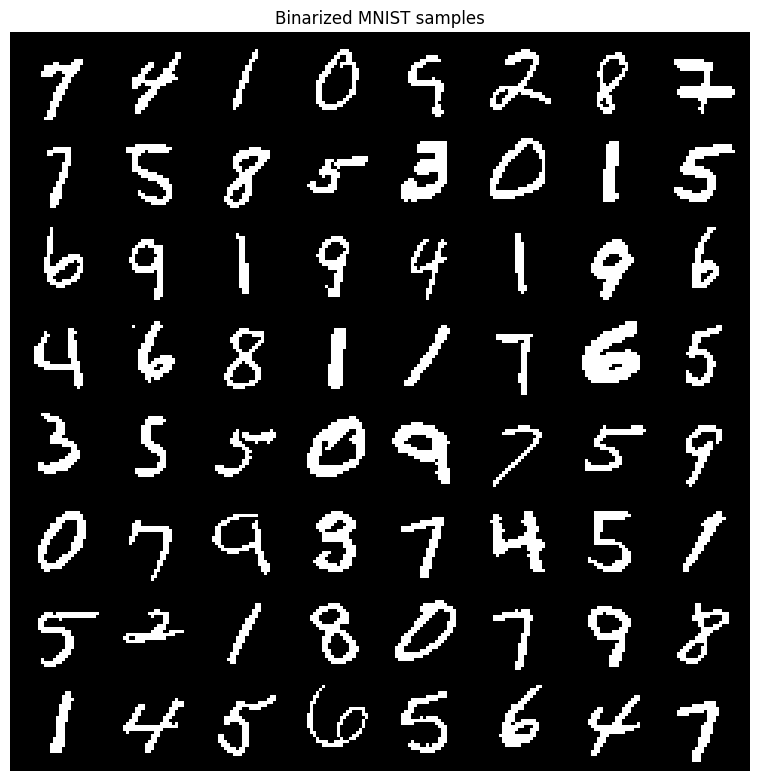

In [11]:
def load_binarized_mnist(threshold: float = 0.5):
    transform = T.Compose([T.ToTensor()])
    train_set = torchvision.datasets.MNIST(root="content/data", train=True, download=True, transform=transform)
    test_set  = torchvision.datasets.MNIST(root="content/data", train=False, download=True, transform=transform)

    x_train = train_set.data.unsqueeze(1).float() / 255.0
    y_train = train_set.targets
    x_test  = test_set.data.unsqueeze(1).float() / 255.0
    y_test  = test_set.targets

    x_train = (x_train > threshold).float()
    x_test  = (x_test  > threshold).float()
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_binarized_mnist(threshold=0.5)
print("MNIST:", x_train.shape, y_train.shape, "unique:", torch.unique(x_train))
print("foreground ratio (mean pixel):", float(x_train.mean().item()))

idx = torch.randperm(x_train.shape[0])[:64]
show_grid([x_train[i,0] for i in idx], nrow=8, title="Binarized MNIST samples", cmap="gray")


patch_pool: torch.Size([1600, 1, 9, 9])


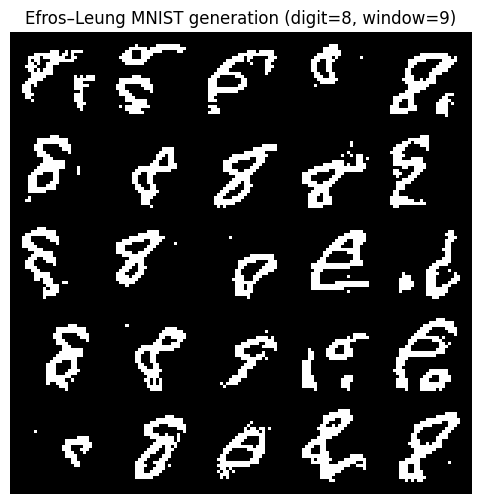

In [12]:
def extract_patches_from_mnist_batch(
    imgs: torch.Tensor,  # (B,1,28,28) in {0,1}
    window: int,
    max_patches: int,
    device: torch.device = device,
) -> torch.Tensor:
    """Return patches: (N,1,window,window) sampled from the batch."""
    assert imgs.ndim == 4 and imgs.shape[1] == 1
    unfold = torch.nn.Unfold(kernel_size=window, padding=0, stride=1)
    patches = unfold(imgs)  # (B, win*win, L)
    B, D, L = patches.shape
    patches = patches.transpose(1, 2).reshape(B * L, 1, window, window)
    if patches.shape[0] > max_patches:
        idx = torch.randperm(patches.shape[0])[:max_patches]
        patches = patches[idx]
    return patches.to(device)

# ---- Part 2 demo (will run after you implement the TODOs) ----
# TODO (tuning): try different digits and hyperparameters; expect *stroke-like* outputs, not perfect digits.
digit = 8 # Select Your Number
window =  9             # TODO (tuning): e.g. 5, 7, 9
num_source_images = 4  # TODO (tuning): more sources -> more variety, slower patch pool build
max_patches = 50000       # TODO (tuning): larger -> better coverage, slower matching

# Optional knobs (not required for correctness)
USE_MNIST_HEURISTICS = True  # set True to try a few stability tweaks on MNIST

src_imgs = x_train[y_train == digit]
sel = torch.randperm(src_imgs.shape[0])[:num_source_images]
src_batch = src_imgs[sel].to(device)

patch_pool = extract_patches_from_mnist_batch(src_batch, window=window, max_patches=max_patches, device=device)
print("patch_pool:", patch_pool.shape)

# Core Efros–Leung parameters
eps =  0.2              # TODO (tuning): smaller -> stricter matching, larger -> more randomness
neighborhood = 8         # TODO

# Heuristic parameters (off by default)
seed_fg_min = 0
border = 0
weighted = False
h_mult = 0.3
if USE_MNIST_HEURISTICS:
    seed_fg_min = 4
    border = 2
    weighted = True
    h_mult = 0.25

n_gen = 25
samples = []
for _ in range(n_gen):
    gen = efros_leung_synthesize_from_patch_pool(
        patches=patch_pool, out_h=28, out_w=28,
        eps=eps, neighborhood=neighborhood,
        seed_fg_min=seed_fg_min, border=border,
        weighted=weighted, h_mult=h_mult,
        verbose=False
    )
    samples.append(gen[0])

show_grid(samples, nrow=5, title=f"Efros–Leung MNIST generation (digit={digit}, window={window})", cmap="gray")


## Part 3 — PixelRNN (binarized MNIST)

Implement a raster-scan autoregressive RNN.

In [12]:
def make_pixel_sequences(x: torch.Tensor):
    """
    x: (B,1,28,28) in {0,1}
    Returns:
      x_in: (B,784) tokens in {0,1,2} where 2 is START
      y:    (B,784) float targets in {0,1}
    """
    B = x.shape[0]
    pixels = x.view(B, -1).long()
    start = torch.full((B, 1), 2, dtype=torch.long)
    x_in = torch.cat([start, pixels[:, :-1]], dim=1)
    y = pixels.float()
    return x_in, y

def make_dataloaders(x_train, x_test, batch_size=128, train_subset=None):
    if train_subset is not None and train_subset < x_train.shape[0]:
        idx = torch.randperm(x_train.shape[0])[:train_subset]
        x_tr = x_train[idx]
    else:
        x_tr = x_train

    x_in_tr, y_tr = make_pixel_sequences(x_tr)
    x_in_te, y_te = make_pixel_sequences(x_test)

    train_ds = TensorDataset(x_in_tr, y_tr)
    test_ds = TensorDataset(x_in_te, y_te)

    num_workers = 2 if device.type == "cuda" else 0
    pin_memory = (device.type == "cuda")

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers,
                              pin_memory=pin_memory, persistent_workers=(num_workers > 0))
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers,
                             pin_memory=pin_memory, persistent_workers=(num_workers > 0))
    return train_loader, test_loader


In [13]:
class PixelRNN(nn.Module):
    def __init__(self, emb_dim=32, hidden_dim=256, num_layers=2, dropout=0.1):
        super().__init__()
        # Tokens: 0, 1, START. (Use START = 2)
        # Positions: row index in [0..27], col index in [0..27]
        #
        # TODO:
        #   - token embedding: nn.Embedding(3, emb_dim)
        #   - row/col embeddings: nn.Embedding(28, emb_dim) each
        #   - LSTM: nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True, ...)
        #   - output head: nn.Linear(hidden_dim, 1) to produce logits for x_t
        #
        # IMPORTANT: this must be a *causal* model. Do NOT peek at future pixels.
        self.emb = nn.Embedding(3,emb_dim)
        self.row_emb = nn.Embedding(28, emb_dim)
        self.col_emb = nn.Embedding(28, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(hidden_dim, 1)

        # Optional convenience (recommended): precompute raster positions for length 784 (T=28*28)
        t = torch.arange(28 * 28)
        self.register_buffer("pos_row", (t // 28).long(), persistent=False)
        self.register_buffer("pos_col", (t % 28).long(), persistent=False)


    def forward(self, x_in: torch.Tensor):
        """
        x_in: (B,784) tokens in {0,1,2}, where 2 denotes START at t=0 (teacher-forcing input).
        Return:
          logits: (B,784) where logits[:,t] parameterizes p(x_t=1 | x_<t)

        Notes:
          - `make_pixel_sequences()` already inserts the START token and shifts the sequence.
          - Add row/col positional embeddings based on t -> (t//28, t%28).
        """

        hn = torch.zeros(self.lstm.num_layers, self.emb.embedding_dim, self.lstm.hidden_size).to(x_in.device)
        cn = torch.zeros(self.lstm.num_layers, self.emb.embedding_dim, self.lstm.hidden_size).to(x_in.device)
        logits = torch.zeros_like(x_in)
        for t in range(x_in[1]):
            emb = self.emb(x_in[:,t])
            if t > 0:
                row_emb = self.row_emb(self.pos_row[t])
                col_emb = self.col_emb(self.pos_col[t])
                emb += row_emb + col_emb
            logit, (hn, cn) = self.lstm(emb, (hn, cn))
            logit = self.dropout(logit)
            logit = self.out(logit)
            
            logits[t] = logit
        return logits

    @torch.no_grad()
    def sample(self, n: int, temperature: float = 1.0):
        """
        Ancestral sampling in raster order.
        Return: samples (n,1,28,28) in {0,1}.

        TODO:
          - Start with prev token = START for all n samples.
          - For t=0..783:
              - embed prev token (+ positional embedding for position t)
              - run 1-step LSTM using cached hidden state
              - map hidden -> logit -> prob
              - sample next pixel using Bernoulli(prob)
              - set prev = sampled pixel token (0/1)
        """
        prev = 2
        for t in range(783):
            prev_emb = self.emb(prev)
            row_emb = self.row_emb(self.pos_row[t])
            col_emb = self.col_emb(self.pos_col[t])
            emb = prev_emb + row_emb + col_emb
            self.lstm()
            pass
        raise NotImplementedError


In [14]:
def evaluate_nll_per_pixel(model: nn.Module, loader: DataLoader):
    model.eval()
    total = 0.0
    count = 0
    bce = nn.BCEWithLogitsLoss(reduction="sum")
    with torch.no_grad():
        for x_in, y in loader:
            x_in = x_in.to(device)
            y = y.to(device)
            logits = model(x_in)
            loss = bce(logits, y)
            total += float(loss.item())
            count += int(y.numel())
    return total / count

def train_pixelrnn(model: nn.Module, train_loader: DataLoader, test_loader: DataLoader, epochs=10, lr=1e-3):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    bce = nn.BCEWithLogitsLoss(reduction="mean")
    history = {"train_loss": [], "test_nll": []}

    for ep in range(1, epochs + 1):
        model.train()
        running = 0.0
        n_batches = 0
        pbar = tqdm(train_loader, desc=f"epoch {ep}/{epochs}")
        for x_in, y in pbar:
            x_in = x_in.to(device)
            y = y.to(device)

            opt.zero_grad(set_to_none=True)
            logits = model(x_in)
            loss = bce(logits, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            running += float(loss.item())
            n_batches += 1
            pbar.set_postfix(loss=running / n_batches)

        train_loss = running / max(1, n_batches)
        test_nll = evaluate_nll_per_pixel(model, test_loader)
        history["train_loss"].append(train_loss)
        history["test_nll"].append(test_nll)
        print(f"epoch {ep}: train_loss={train_loss:.4f} | test_nll/pixel={test_nll:.4f}")

    return history


### PixelRNN tuning helper (optional but recommended)

A simple hyperparameter sweep runner. Use a small `train_subset` and few epochs so you can iterate quickly.
Then train your best configuration longer for the final results.


In [15]:
def sweep_pixelrnn_configs(
    x_train: torch.Tensor,
    x_test: torch.Tensor,
    configs: list[dict],
    train_subset: int = 10000,
    epochs: int = 2,
    batch_size: int = 128,
):
    """
    Sweep a list of PixelRNN configs.

    Each entry in `configs` is a dict like:
      {
        "model_kwargs": {"emb_dim": 32, "hidden_dim": 256, "num_layers": 2, "dropout": 0.1},
        "lr": 1e-3,
      }

    TODO:
      - For each config:
          * make loaders with make_dataloaders(..., train_subset=train_subset)
          * instantiate PixelRNN(**model_kwargs)
          * train with train_pixelrnn(..., epochs=epochs, lr=lr)
          * evaluate test_nll_per_pixel via evaluate_nll_per_pixel
      - Return a list of results sorted by test_nll (ascending)
    """
    raise NotImplementedError


In [1]:
# ---- Part 3 demo (will run after you implement PixelRNN) ----
# TODO (tuning): change model size and training hyperparameters; report test NLL/pixel + sample quality.
BATCH_SIZE = 32
TRAIN_SUBSET = 10000   # e.g., 10000 for quick debugging / sweeps
EPOCHS = 10
LR =  1e-3# e.g.,1e-3

MODEL_KWARGS = dict(
    emb_dim= 16,        # TODO (tuning)
    hidden_dim= 256,    # TODO (tuning)
    num_layers= 2,      # TODO (tuning)
    dropout=0.1,
)

TEMPERATURE = 1.0     # TODO (tuning)e.g.,0.7～1.3

train_loader, test_loader = make_dataloaders(
    x_train, x_test,
    batch_size=BATCH_SIZE,
    train_subset=TRAIN_SUBSET,
)

model = PixelRNN(**MODEL_KWARGS).to(device)
history = train_pixelrnn(model, train_loader, test_loader, epochs=EPOCHS, lr=LR)

plt.figure()
plt.plot(range(1, len(history["train_loss"]) + 1), history["train_loss"], marker="o")
plt.xlabel("epoch")
plt.ylabel("train BCE (mean)")
plt.title("PixelRNN training curve")
plt.grid(True)
plt.show()

samples = model.sample(n=64, temperature=TEMPERATURE)
show_grid([samples[i, 0] for i in range(64)], nrow=8, title="PixelRNN samples (binary MNIST)", cmap="gray")


NameError: name 'make_dataloaders' is not defined